## Example pipeline for netrd
This notebook uses netrd to compute the average of all distances between all reconstructions across 3 synthetic datasets. It is an example of exactly 1 way that netrd can be used in experimentation.
### IMPORTANT: If you want to play and make changes, please go to FIle --> Make a Copy first and play in your copy notebook!!!
Git and notebooks do not get along great, it will be easier for everyone if this one is not changed.

In [1]:
import netrd
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## Load datasets
datasets = {'4-clique':netrd.utilities.read_time_series('../data/synth_4clique_N64_simple.csv'), \
           'BA':netrd.utilities.read_time_series('../data/synth_BAnetwork_N64_simple.csv'), \
           'ER':netrd.utilities.read_time_series('../data/synth_ERnetwork_N64_simple.csv')}

In [3]:
## Load reconstruction methods
reconstructors = {'random':netrd.reconstruction.RandomReconstructor(), \
                  'correlation_matrix':netrd.reconstruction.CorrelationMatrixReconstructor(), \
                  'convergent_crossmappings':netrd.reconstruction.ConvergentCrossMappingReconstructor(), \
                  'exact_mean_field':netrd.reconstruction.ExactMeanFieldReconstructor(), \
                  'free_energy_minimization':netrd.reconstruction.FreeEnergyMinimizationReconstructor(), \
                  'graphical_lasso':netrd.reconstruction.GraphicalLassoReconstructor(), \
                  'maximum_likelihood':netrd.reconstruction.MaximumLikelihoodEstimationReconstructor(), \
                  'mutual_information':netrd.reconstruction.MutualInformationMatrixReconstructor(), \
                  'ou_inference':netrd.reconstruction.OUInferenceReconstructor(), \
                  'partial_correlation':netrd.reconstruction.PartialCorrelationMatrixReconstructor(), \
                  'regularized_correlation':netrd.reconstruction.RegularizedCorrelationMatrixReconstructor(), \
                  'thouless_anderson_palmer':netrd.reconstruction.ThoulessAndersonPalmerReconstructor(), \
                  'time_granger_causality':netrd.reconstruction.TimeGrangerCausalityReconstructor(), \
                  'marchenko_pastur':netrd.reconstruction.MarchenkoPastur(), \
                  #'naive_transfer_entropy':netrd.reconstruction.NaiveTransferEntropyReconstructor()
                 }

In [4]:
## Load distance methods
distance_methods = {'jaccard':netrd.distance.JaccardDistance(), \
                    'hamming':netrd.distance.Hamming(), \
                    'hamming_ipsen_mikhailov':netrd.distance.HammingIpsenMikhailov(), \
                    'portrait_divergence':netrd.distance.PortraitDivergence(), \
                    'resistance_perturbation':netrd.distance.ResistancePerturbation(), \
                    'frobenius':netrd.distance.Frobenius(), \
                    'netsimilie':netrd.distance.NetSimile()
                   }

In [5]:
## get the names of the methods
reconstruction_methods = [method for method in reconstructors.keys()]
distance_methods_list = [method for method in distance_methods.keys()]

In [6]:
## Dictionary of dictionaries containing the reconstructed networks
## <dataset_name, <recon_method_name, reconstructed_graph>
networks = defaultdict(dict)

In [7]:
## First get all of the reconstructions for every dataset
print('Computing network reconstructions')
for data_name, time_series in datasets.items():
    print('dataset: ' + str(data_name))
    for reconstruction_method, reconstructor in reconstructors.items():
        print(reconstruction_method + '...', end='')
        networks[data_name][reconstruction_method] = reconstructor.fit(time_series)
        print('done')

Computing network reconstructions
dataset: BA
time_granger_causality...done
partial_correlation...done
marchenko_pastur...done
ou_inference...done
correlation_matrix...done
mutual_information...done
random...done
regularized_correlation...done
convergent_crossmappings...done
exact_mean_field...done
graphical_lasso...done
thouless_anderson_palmer...done
free_energy_minimization...done
maximum_likelihood...done
dataset: ER
time_granger_causality...done
partial_correlation...done
marchenko_pastur...done
ou_inference...done
correlation_matrix...done
mutual_information...done
random...done
regularized_correlation...done
convergent_crossmappings...done
exact_mean_field...done
graphical_lasso...done
thouless_anderson_palmer...done
free_energy_minimization...done
maximum_likelihood...done
dataset: 4-clique
time_granger_causality...done
partial_correlation...done
marchenko_pastur...done
ou_inference...done
correlation_matrix...done
mutual_information...done
random...done
regularized_correlation

In [8]:
## 4-deep dict structure: <dataset_name, <rmethod1, <rmethod2, <dmethod, distance> > > >  
distances = dict()
## In order to standardize, I am going to collect all of the 
## outputs for each distance
## TODO should I standardize across all datasets, or within each...
## My hunch is that within each would be better
per_distance_values = dict()

In [9]:
## Then, compute the distance between every reconstruction of every network
print('Computing network distances')
for data_name, networks_dict in networks.items():
    per_distance_values[data_name] = defaultdict(list)
    print('dataset: ' + str(data_name))
    distances[data_name] = dict()
    for distance_method, distance_function in distance_methods.items():
        print(distance_method + '...', end='')
        for reconstruction_method1, network1 in networks_dict.items():
            distances[data_name].setdefault(reconstruction_method1, dict())
            for reconstruction_method2, network2 in networks_dict.items():
                distances[data_name][reconstruction_method1].setdefault(reconstruction_method2, dict())
                distance = distance_function.dist(network1, network2)
                distances[data_name][reconstruction_method1][reconstruction_method2].setdefault(distance_method, dict) 
                distances[data_name][reconstruction_method1][reconstruction_method2][distance_method] = distance
                per_distance_values[data_name][distance_method].append(distance)
        print('done')

Computing network distances
dataset: BA
jaccard...done
portrait_divergence...done
hamming...done
hamming_ipsen_mikhailov...done
frobenius...done
resistance_perturbation...done
netsimilie...done
dataset: ER
jaccard...done
portrait_divergence...done
hamming...done
hamming_ipsen_mikhailov...done
frobenius...done
resistance_perturbation...done
netsimilie...done
dataset: 4-clique
jaccard...done
portrait_divergence...done
hamming...done
hamming_ipsen_mikhailov...done
frobenius...done
resistance_perturbation...done
netsimilie...done


In [10]:
## For each distance, store (max,min) tuple to use in standardization
max_min_distance_values = defaultdict(dict)
for data_name in networks.keys():
    for distance_method in distance_methods_list:
        max_min_distance_values[data_name][distance_method]= \
        (np.max(per_distance_values[data_name][distance_method]), np.min(per_distance_values[data_name][distance_method]))

In [11]:
## Show results

In [12]:
number_of_reconstructors = len(reconstruction_methods)
name_map = {reconstruction_methods[i]:i for i in range(number_of_reconstructors)}

In [13]:
similarity_matrix = np.zeros((number_of_reconstructors,number_of_reconstructors))
for data_name, dataset_dict in distances.items():
    for method1, method1_dict in dataset_dict.items():
        for method2, method2_dict in dataset_dict.items():
            for distance_method in method1_dict[method2].keys():
                max_dist_val, min_dist_val = max_min_distance_values[data_name][distance_method]
                similarity_matrix[name_map[method1], name_map[method2]] += \
                (method1_dict[method2][distance_method] - min_dist_val) / (max_dist_val - min_dist_val)

In [14]:
avg_similarity = similarity_matrix / (number_of_reconstructors*len(datasets))

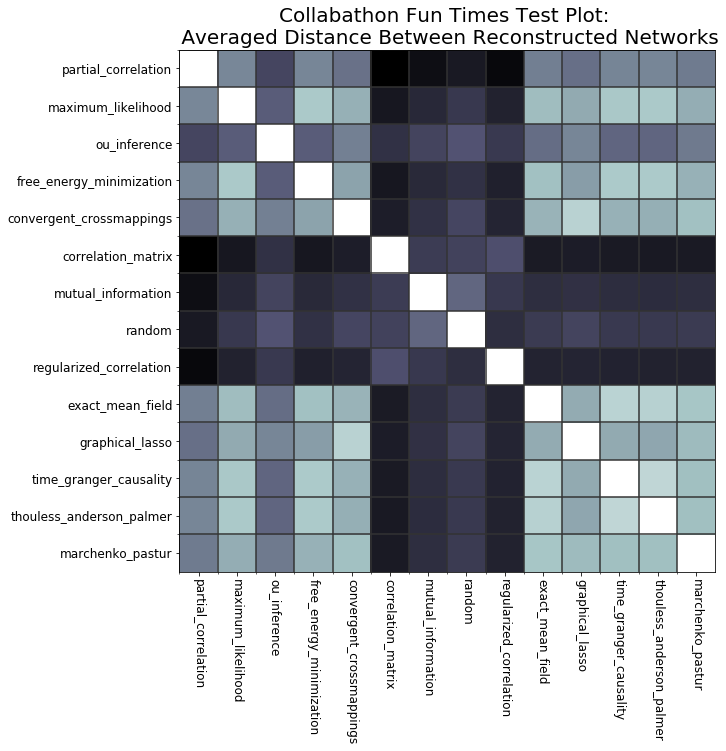

In [15]:
######## matrix goes here ##########
reconstruction_names = list(name_map.keys())
N_methods = len(reconstruction_names)
#mat = np.random.rand(N_methods,N_methods)
mat = avg_similarity
#### plotting parameters ####
netrd_cmap = 'bone_r'
method_id = 'test'
width = 1.2
heigh = 1.2
mult  = 8.0

###### plot the mat ###########
fig, ax0 = plt.subplots(1, 1, figsize=(width*mult,heigh*mult))

ax0.imshow(mat, aspect='auto', cmap=netrd_cmap)

###### be obsessive about it ###########
ax0.set_xticks(np.arange(0, N_methods, 1))
ax0.set_yticks(np.arange(0, N_methods, 1))
# ax0.set_xticklabels(np.arange(0, N_methods, 1), fontsize=2.0*mult)
# ax0.set_yticklabels(np.arange(0, N_methods, 1), fontsize=2.0*mult)
ax0.set_xticklabels(reconstruction_names, fontsize=1.5*mult, rotation=270)
ax0.set_yticklabels(reconstruction_names, fontsize=1.5*mult)
ax0.set_xticks(np.arange(-.5, N_methods-0.5, 1), minor=True)
ax0.set_yticks(np.arange(-.5, N_methods-0.5, 1), minor=True)
ax0.grid(which='minor', color='#333333', linestyle='-', linewidth=1.5)

ax0.set_title("Collabathon Fun Times Test Plot: \n Averaged Distance Between Reconstructed Networks", 
              fontsize=2.5*mult)

#plt.savefig("../figs/pngs/collabathon_output1.png", bbox_inches='tight', dpi=425)
# plt.savefig("../figs/pdfs/%collabathon_output1.pdf"%method_id, bbox_inches='tight')
plt.show()